Import the necessary libraries to define the domain mesh. The dolfinx, mesh package creates a domain of unit square mesh with the given dimensions in parethesis. The MPI command specifies how each mesh behaves in parallel. The code below describe the domain as a square subdivided into two triangular elements. Note that as long as mesh type is not specified triangular mesh is the default.

In [1]:
from mpi4py import MPI
from dolfinx import mesh
import numpy as np
import pyvista
from mpi4py import MPI
from dolfinx import mesh
from dolfinx.fem import FunctionSpace
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as pl
import ufl

from dolfinx.fem import (Constant, Function, FunctionSpace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical)
from dolfinx.fem.petsc import LinearProblem
from dolfinx.mesh import create_unit_square
from mpi4py import MPI
from petsc4py.PETSc import ScalarType
from ufl import SpatialCoordinate, TestFunction, TrialFunction, dot, ds, dx, grad


domain = mesh.create_unit_square(MPI.COMM_WORLD, 10, 10)
#describe the domain as a square subdivided into two triangular elements

Next we define our finite element function space V. The type of element 'CG' is the standard lagrange family element.

In [2]:
from dolfinx.fem import FunctionSpace
V = FunctionSpace(domain, ("CG", 1))
#create finite element function space


Next we define our trial and test functions T_a and T_t over the function space V.

In [3]:
from ufl import Constant, dx, grad, inner, TestFunction, TrialFunction
T_a = TrialFunction(V)
T_t = TestFunction(V)
    #Define the trial and test functions on the same functionspace V
   

The next step is to define our boundary conditions. The code below defines the location of the boundary condition.\n",
    "The first step is to define the function . Into this function, we would like to interpolate the boundary condition e^(x + y/2). We do this by first defining a dolfinx.fem.Function, and then using a lambda-function in Python to define the spatially varying function.

In [4]:
from dolfinx import fem
from numpy import exp
gD = fem.Function(V)
gD.interpolate(lambda x: exp(x[0] + x[1]/2.))
    
#describe the location of the boundary condition

Next we would like to apply the boundary values to all degrees of freedom that are on the boundary of the discrete domain. We start by identifying the facets (line-segments) representing the outer boundary, using dolfinx.mesh.exterior_facet_indices.

In [5]:
import numpy
#Create facet to cell connectivity required to determine boundary facets
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)

#define dirichlet boundary condition

Next we create the dirichlet boundary conditions

In [6]:
boundary_dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
bc = fem.dirichletbc(gD, boundary_dofs)

next we define x as a point on the spatial coordinate of the domain.

In [7]:
from dolfinx import fem, mesh, plot
from petsc4py.PETSc import ScalarType 
from ufl import (Circumradius, FacetNormal, SpatialCoordinate, TrialFunction, TestFunction, div, dx, ds, grad, inner)

x = SpatialCoordinate(domain)
#get coordinates

Next, we create a function containing the exact solution (which will also be used in the Dirichlet boundary condition) and the corresponding source function for the right hand side. Note that we use ufl.SpatialCoordinate to define the exact solution, which in turn is interpolated into gD and used to create the source function f.

In [8]:
from ufl import exp
rhsf = 5/4 * exp(x[0] + x[1]/2)
gD.interpolate(fem.Expression(rhsf, V.element.interpolation_points()))
S = dot(grad(T_a), grad(T_t)) * dx
f = T_t*rhsf*dx 
# right hand side function, rhsf

As we now have the variational form, we can solve the linear problem.

In [9]:
# Define and compute solution
problem = fem.petsc.LinearProblem(S, f, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
T_i = problem.solve()

We will visualizing the mesh using pyvista, an interface to the VTK toolkit. We start by converting the mesh to a format that can be used with pyvista. To do this we use the function dolfinx.plot.create_vtk_mesh. The first step is to create an unstructured grid that can be used by pyvista. We need to start a virtual framebuffer for plotting through docker containers. You can print the current backend and change it with pyvista.set_jupyter_backend(backend).

In [10]:
import pyvista
print(pyvista.global_theme.jupyter_backend)
   

trame


Below we have a plot of wha the domain mesh looks like.

In [11]:
from dolfinx import plot
pyvista.start_xvfb()
topology, cell_types, geometry = plot.create_vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)



No module named 'trame'

Falling back to a static output.
  warnings.warn(



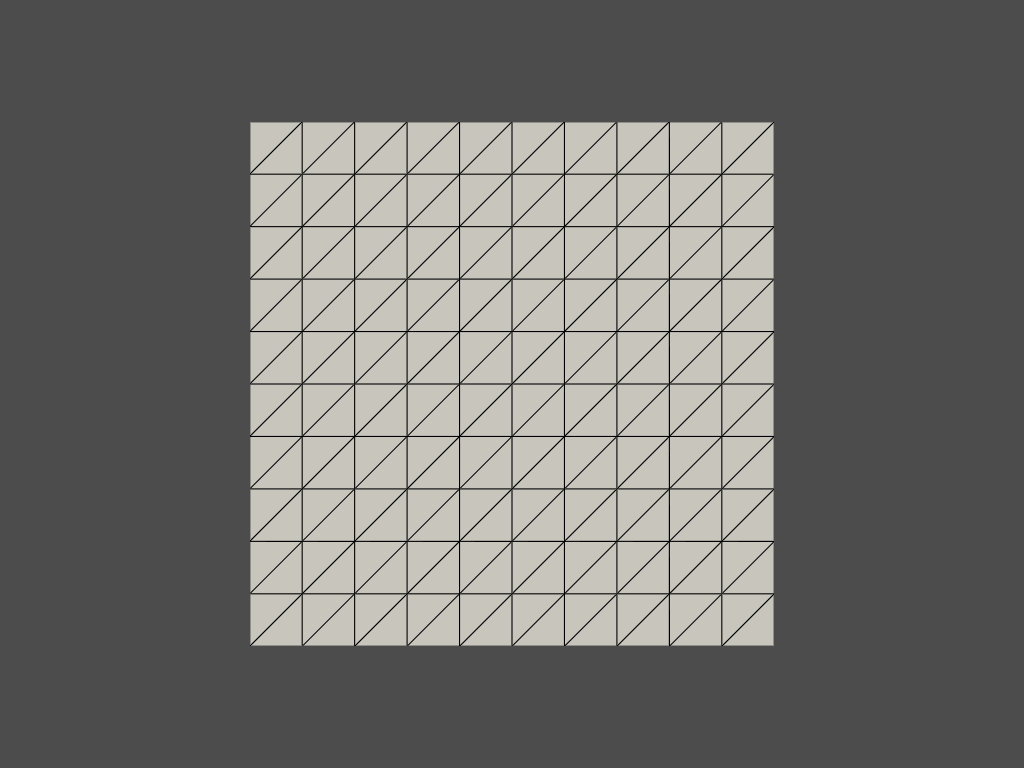

In [12]:
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")

We want to plot the solution T_i. As the function space used to defined the mesh is disconnected from the function space defining the mesh, we create a mesh based on the dof coordinates for the function space V. We use dolfinx.plot.create_vtk_mesh with the function space as input to create a mesh with mesh geometry based on the dof coordinates.

In [13]:
u_topology, u_cell_types, u_geometry = plot.create_vtk_mesh(V)

Next, we create the pyvista.UnstructuredGrid and add the dof-values to the mesh.


No module named 'trame'

Falling back to a static output.
  warnings.warn(



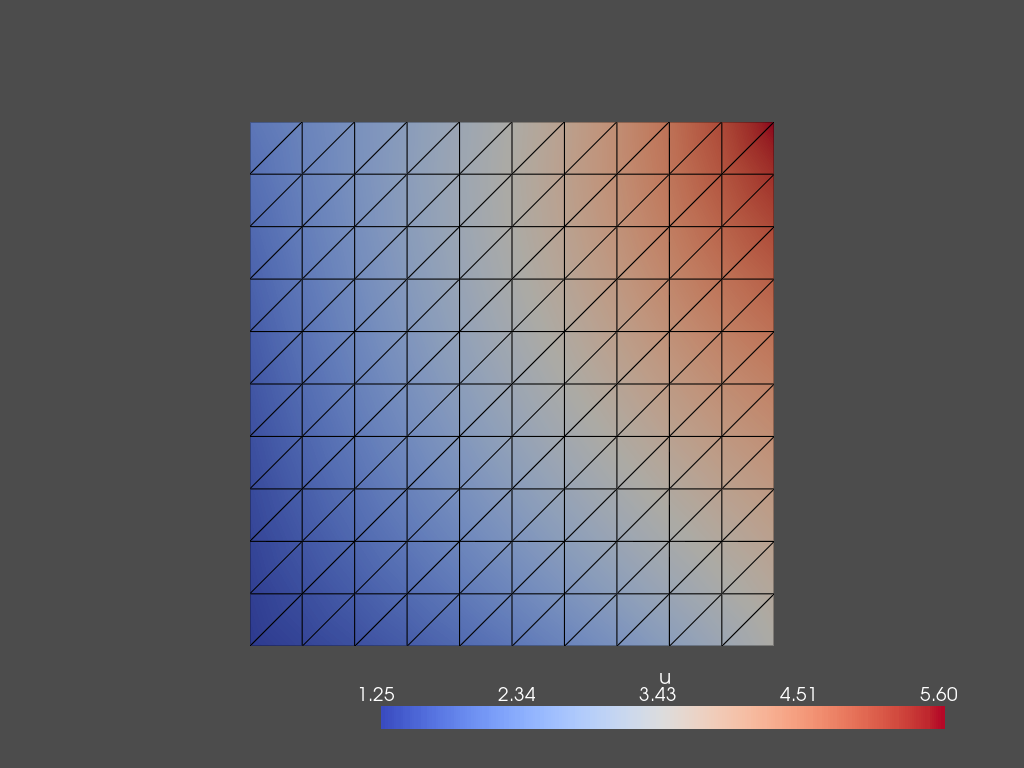

In [14]:
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = T_i.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True, cmap='coolwarm')
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

In the plot above there is a single boundary condition applied at all dofs.
Below we will translate the code in a way that the vertical bc is described by dirichlet conditions and the horizontal bc described by neumann conditions

So far the boundary condition at all dofs is set at the dirichlet conditions. However the data on the PEPS II paper has a boundary condition defined both by Dirichlet and neumann conditions.

In [32]:
import numpy as np
import pyvista

from dolfinx.fem import (Constant, Function, FunctionSpace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical)
from dolfinx.fem.petsc import LinearProblem
from dolfinx.mesh import create_unit_square
from mpi4py import MPI
from petsc4py.PETSc import ScalarType
from ufl import SpatialCoordinate, TestFunction, TrialFunction, dot, ds, dx, grad, as_vector, exp, FacetNormal

def Solve_poisson(NE=10, degree=1):
    mesh = create_unit_square(MPI.COMM_WORLD, NE, NE)
    V = FunctionSpace(mesh, ("CG", 1))
    T_a = TrialFunction(V)
    T_t = TestFunction(V)
    S = dot(grad(T_a), grad(T_t)) * dx
    
    def u_exact(x):
        return np.exp(x[0] + x[1]/2.)

    def boundary_D(x):
        return np.logical_or(np.isclose(x[0], 0), np.isclose(x[0],1))

    dofs_D = locate_dofs_geometrical(V, boundary_D)
    u_bc = Function(V)
    u_bc.interpolate(u_exact)
    bc = dirichletbc(u_bc, dofs_D)
    x = SpatialCoordinate(mesh)
    g = -4 * x[1]
    gN = as_vector((exp(x[0] + x[1]/2.), 0.5*exp(x[0] + x[1]/2.)))
    rhsf = -5./4.*exp(x[0] + x[1]/2.)
    n = FacetNormal(mesh)
    
    #f = Constant(mesh, ScalarType(-6))
    L =  T_t*rhsf*dx + T_t *dot(gN,n)*ds
    #f = T_t*rhsf*dx + T_t*inner(gN, n)*ds
    problem = LinearProblem(S, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    T_i = problem.solve()
    return T_i


In [34]:
T_i = Solve_poisson()

err, diff = evaluate_error(T_i)

INFO:root:running build_ext
INFO:root:building 'libffcx_forms_766d475de9ed1283c235bc842b686d7f3ca6b884' extension
INFO:root:clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /Users/kteshome/anaconda3/envs/fenicsx-env/include -arch arm64 -fPIC -O2 -isystem /Users/kteshome/anaconda3/envs/fenicsx-env/include -arch arm64 -I/Users/kteshome/anaconda3/envs/fenicsx-env/lib/python3.10/site-packages/ffcx/codegeneration -I/Users/kteshome/anaconda3/envs/fenicsx-env/include/python3.10 -c libffcx_forms_766d475de9ed1283c235bc842b686d7f3ca6b884.c -o ./libffcx_forms_766d475de9ed1283c235bc842b686d7f3ca6b884.o -O2 -g0
INFO:root:clang -bundle -undefined dynamic_lookup -Wl,-rpath,/Users/kteshome/anaconda3/envs/fenicsx-env/lib -L/Users/kteshome/anaconda3/envs/fenicsx-env/lib -Wl,-rpath,/Users/kteshome/anaconda3/envs/fenicsx-env/lib -L/Users/kteshome/anaconda3/envs/fenicsx-env/lib ./libffcx_forms_766d475de9ed1283c235bc842b686d7f3ca6b884.o -o ./libffcx_fo

Error_L2 : 6.63e-04


In [35]:
diff

Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1, variant='equispaced'), dim=2, variant='equispaced'), 23), FiniteElement('Lagrange', triangle, 1)), 80)


No module named 'trame'

Falling back to a static output.
  warnings.warn(



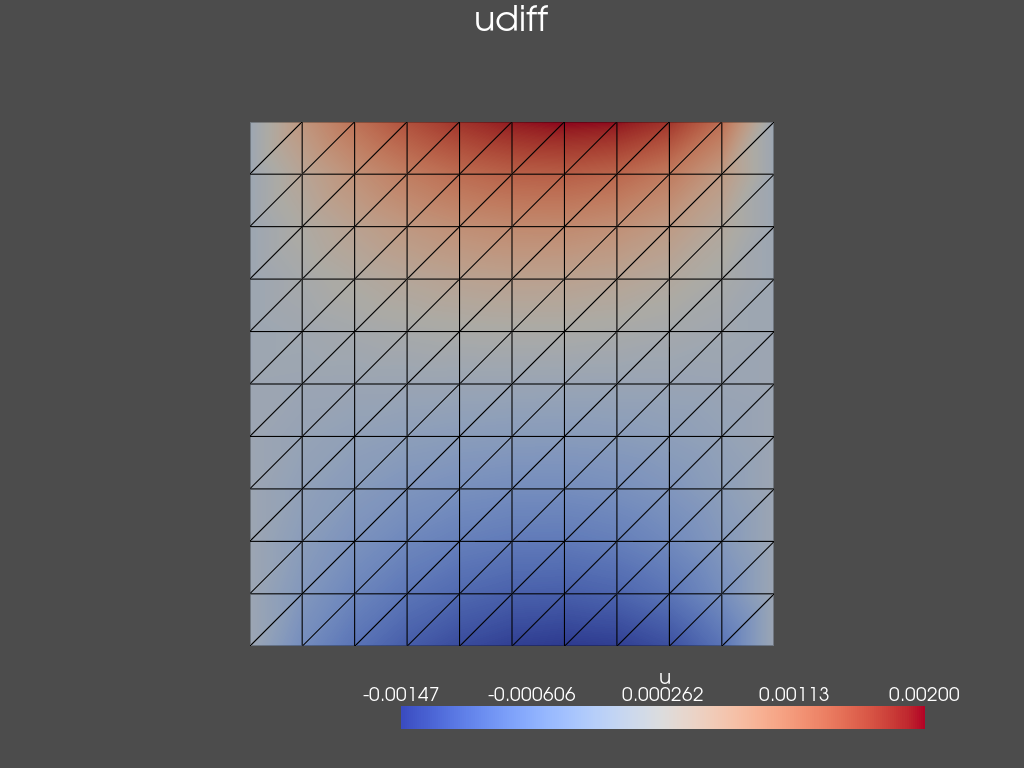

In [36]:
pyvista.start_xvfb()

from dolfinx.plot import create_vtk_mesh
pyvista_cells, cell_types, geometry = create_vtk_mesh(T_i.function_space)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.point_data["u"] = diff.x.array
grid.set_active_scalars("u")

plotter = pyvista.Plotter()
plotter.add_text("udiff", position="upper_edge", font_size=14)
plotter.add_mesh(grid, show_edges=True, cmap = 'coolwarm')
plotter.view_xy()

if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("neumann_dirichlet.png")

Below we will be performing a convergence test on our data. 

In [38]:
#from petsc4py import PETSc

degrees = [1, 2]
NElements = [10, 20, 40, 80, 160, 320, 640]

#for NE in NElements:
 #   errors_L2.append(errorL2)
  #  print('NE=',NE, 'error_L2=', errorL2)

    
    
    
    
#for degree in degrees:
 #  errorL2 = []

for degree in degrees:
    for NE in NElements:
        # Solve the Poisson problem for the given degree and NE
        
        T_i = Solve_poisson(NE, degree)

        # Calculate the L2 error
        error, diff = evaluate_error(T_i)

        # Print the results
        print(f"degree: {degree}, NE: {NE}, Error: {error:.2e}")
   

Error_L2 : 6.63e-04
degree: 1, NE: 10, Error: 6.63e-04
Error_L2 : 1.68e-04
degree: 1, NE: 20, Error: 1.68e-04
Error_L2 : 4.22e-05
degree: 1, NE: 40, Error: 4.22e-05
Error_L2 : 1.05e-05
degree: 1, NE: 80, Error: 1.05e-05
Error_L2 : 2.64e-06
degree: 1, NE: 160, Error: 2.64e-06
Error_L2 : 6.59e-07
degree: 1, NE: 320, Error: 6.59e-07
Error_L2 : 1.65e-07
degree: 1, NE: 640, Error: 1.65e-07
Error_L2 : 6.63e-04
degree: 2, NE: 10, Error: 6.63e-04
Error_L2 : 1.68e-04
degree: 2, NE: 20, Error: 1.68e-04
Error_L2 : 4.22e-05
degree: 2, NE: 40, Error: 4.22e-05
Error_L2 : 1.05e-05
degree: 2, NE: 80, Error: 1.05e-05
Error_L2 : 2.64e-06
degree: 2, NE: 160, Error: 2.64e-06
Error_L2 : 6.59e-07
degree: 2, NE: 320, Error: 6.59e-07
Error_L2 : 1.65e-07
degree: 2, NE: 640, Error: 1.65e-07
